In [25]:
# Author: Banafsheh Khazali and Shokoofa Ghods
# Date: March 06, 2023

## Libraries

In [26]:
import os
from os import listdir
from os.path import join, isfile
from PIL import Image

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision.transforms import transforms
from torch.utils.data import random_split

In [27]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# !unzip -q "/content/drive/MyDrive/Data/Dataset.zip" -d "/content/drive/MyDrive/Dataset"

# Load the csv file containing the image file names and corresponding labels

In [29]:
data = pd.read_csv('/content/drive/MyDrive/train.csv')
data

,id,label
0,train/1.jpg,3
1,train/2.jpg,80
2,train/3.jpg,95
3,train/4.jpg,78
4,train/5.jpg,85
...,...,...
4130,train/4131.jpg,35
4131,train/4132.jpg,74
4132,train/4133.jpg,6
4133,train/4134.jpg,67


In [30]:
np_data = data.values

# Define Transformers

In [31]:
from torchvision.transforms import transforms

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomApply([transforms.RandomRotation(degrees=(-30, 30))], p = 0.2),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((224, 224)),
])


# Map images to their labels

In [32]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # Get the filename and label for the current index
        filename = self.data[index][0]
        label = self.data[index][1]
        
        # Load the image and apply the transformations
        image = Image.open('/content/drive/MyDrive/train/' + filename)
        if self.transform:
            image = self.transform(image)
            label = torch.tensor(label)
        
        # Return the image and label as tensors
        return image, label

    def number_of_classes(self):
      return self.data[:,1].max() + 1

In [33]:
def visualization(image, label):
  plt.figure(figsize= (10,8))
  plt.imshow(image.permute(1,2,0))
  plt.title(label.item())
  plt.xticks([])
  plt.yticks([])
  plt.show()

# Load the train dataset from the folder

In [34]:
train_dataset = CustomDataset(np_data, transform=train_transform)


# Split the data into train and validation sets 

In [35]:
n_total = len(train_dataset)
n_train = int(n_total * 0.8)
n_val = n_total - n_train
train_data, val_data = random_split(train_dataset, [0.8, 0.2])

## Visualize one sample

torch.Size([3, 224, 224])


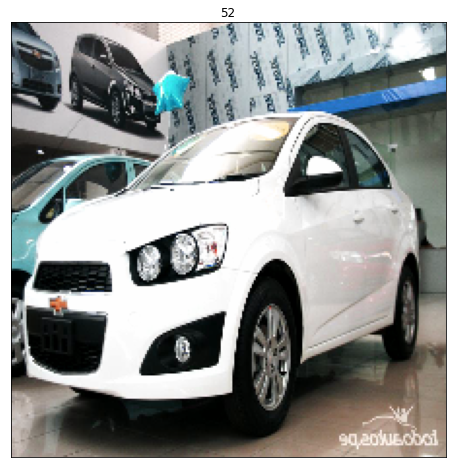

In [37]:
img, label = train_dataset[100]
print(img.shape)
visualization(img, label)

# Create data loaders for the train and validation sets



In [39]:
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=32,
    shuffle=True,
)

val_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=32,
    shuffle=False,
)

# Define the neural network model architecture

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.googlenet(weights=torchvision.models.GoogLeNet_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, train_dataset.number_of_classes())
model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

# Define loss and optimizer

In [44]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(device)

cuda


# Train the model

In [45]:
def evaluate(model, loader, device, criterion, mode='validation'):
  model.eval()
  total_correct = 0
  total_loss = 0
  total = 0
  for i, (images, labels) in enumerate(loader):
    images = images.to(device)
    labels = labels.to(device)
    with torch.no_grad():
      outputs = model(images)
      loss = criterion(outputs, labels)
      total_loss += loss.item() * images.size(0)
      total += images.size(0)
      _, predictions = outputs.max(1)
      total_correct += (labels == predictions).sum()
  loss = total_loss / total
  accuracy = total_correct / total
  print(f'{mode} epoch {epoch}: Loss({loss:6.4f}) Accuracy ({accuracy:6.4f})')



In [1]:
epochs = 50
for epoch in range(epochs):
  model.train()
  total = 0
  total_correct = 0
  total_loss = 0
  total_l = 0
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    total += images.size(0)
    _, predictions = outputs.max(1)
    total_correct += (predictions == labels).sum()
    total_loss += loss.item() * images.size(0)
    if (i%10 == 0):
      print(total_loss/total)
  accuracy = total_correct / total
  loss = total_loss / total
  print(f'Train epoch {epoch}: Loss({loss:6.4f}) Accuracy ({accuracy:6.4f})')
  evaluate(model, val_loader, device, criterion, mode='valid')

In [ ]:
torch.save(model.state_dict(), 'model.pt')
